# Fraser Health Synthetic Data Generation - Onboarding Notebook

This notebook serves as an interactive controller for generating synthetic health data for Fraser Health (British Columbia) using the Synthea simulator.

**Key Features:**
- Uses existing geography/provider files from synthea-international (ca folder)
- No external Map APIs or file generation from scratch
- Programmatically reads and utilizes existing schemas
- Targets Fraser Health cities: Surrey, Burnaby, New Westminster, Coquitlam

**Prerequisites:**
- Java 11 or higher
- Python 3.7+
- pandas, matplotlib libraries

## Section 1: Environment Setup & Repo Inspection

In [43]:
# OPTIONAL: Create and activate a dedicated Python environment BEFORE running this notebook

# From a terminal in the project folder (recommended on Linux/macOS):

#   python -m venv .venv

#   source .venv/bin/activate

#   pip install --upgrade pip

#   pip install -r requirements.txt


### 1.1 Install Required Python Dependencies

In [44]:
import sys
import subprocess

# # Install required packages
# !pip install pandas matplotlib numpy ipywidgets

### 1.2 Check Java Installation

In [45]:
import subprocess
import re
import os
from pathlib import Path

# Java 17-21 required for Gradle compatibility (Java 25+ causes "Unsupported class file major version" errors)
# Define multiple potential Java installation paths (ordered by preference)
JAVA_CANDIDATES = [
    # Codespaces / SDKMAN paths (most common in GitHub Codespaces)
    Path("/home/codespace/java/21.0.9-ms"),
    Path("/usr/local/sdkman/candidates/java/21.0.9-ms"),
    # Standard Linux paths
    Path("/usr/lib/jvm/java-21-openjdk-amd64"),
    Path("/usr/lib/jvm/java-17-openjdk-amd64"),
    # macOS paths
    Path("/Library/Java/JavaVirtualMachines/temurin-21.jdk/Contents/Home"),
    Path("/Library/Java/JavaVirtualMachines/temurin-17.jdk/Contents/Home"),
]

def find_compatible_java():
    """Find a compatible Java installation (Java 11-21)"""
    for java_home in JAVA_CANDIDATES:
        java_bin = java_home / "bin" / "java"
        if java_bin.exists():
            return java_home, java_bin
    return None, None

COMPATIBLE_JAVA_HOME, COMPATIBLE_JAVA_BIN = find_compatible_java()

def check_java_version():
    """Check if Java 11-21 is installed and warn about Java 25+ compatibility issues"""
    # Try compatible Java first, then fallback to system Java
    if COMPATIBLE_JAVA_BIN and COMPATIBLE_JAVA_BIN.exists():
        java_cmd = str(COMPATIBLE_JAVA_BIN)
    else:
        java_cmd = 'java'
    
    try:
        result = subprocess.run([java_cmd, '-version'], 
                              capture_output=True, 
                              text=True, 
                              check=True)
        version_output = result.stderr  # Java outputs version to stderr
        print("Java version output:")
        print(version_output)
        
        # Extract version number
        version_match = re.search(r'version "(\d+)', version_output)
        if version_match:
            major_version = int(version_match.group(1))
            if major_version >= 11 and major_version <= 21:
                print(f"\n✓ Java {major_version} is installed (meets requirement: Java 11-21)")
                return True, java_cmd
            elif major_version > 21:
                # Check if compatible Java is available as fallback
                if COMPATIBLE_JAVA_BIN and COMPATIBLE_JAVA_BIN.exists():
                    print(f"\n⚠ Java {major_version} detected in PATH but may cause Gradle compatibility issues")
                    print(f"✓ Using compatible Java from {COMPATIBLE_JAVA_HOME} for Synthea build/run")
                    # Re-check version of compatible Java
                    compat_result = subprocess.run([str(COMPATIBLE_JAVA_BIN), '-version'],
                                                   capture_output=True, text=True)
                    compat_match = re.search(r'version "(\d+)', compat_result.stderr)
                    if compat_match:
                        compat_version = int(compat_match.group(1))
                        print(f"  Compatible Java version: {compat_version}")
                    return True, str(COMPATIBLE_JAVA_BIN)
                else:
                    print(f"\n⚠ Java {major_version} is installed but Gradle may not support it")
                    print("  Searching for compatible Java (11-21)...")
                    print("  Please install Java 17 or 21: sudo apt install openjdk-17-jdk")
                    return False, java_cmd
            else:
                print(f"\n✗ Java {major_version} is installed but version 11+ is required")
                return False, java_cmd
        else:
            print("\n⚠ Could not determine Java version")
            return False, java_cmd
    except FileNotFoundError:
        print("✗ Java is not installed or not in PATH")
        print("Please install Java 17: sudo apt install openjdk-17-jdk")
        return False, None
    except Exception as e:
        print(f"✗ Error checking Java version: {e}")
        return False, None

java_ok, JAVA_CMD = check_java_version()
print(f"\nJava command to use: {JAVA_CMD}")
if COMPATIBLE_JAVA_HOME:
    print(f"JAVA_HOME for builds: {COMPATIBLE_JAVA_HOME}")

Java version output:
openjdk version "21.0.9" 2025-10-21 LTS
OpenJDK Runtime Environment Microsoft-12574458 (build 21.0.9+10-LTS)
OpenJDK 64-Bit Server VM Microsoft-12574458 (build 21.0.9+10-LTS, mixed mode, sharing)


✓ Java 21 is installed (meets requirement: Java 11-21)

Java command to use: /home/codespace/java/21.0.9-ms/bin/java
JAVA_HOME for builds: /home/codespace/java/21.0.9-ms


### 1.3 Clone Synthea Repositories

In [46]:
import os
from pathlib import Path

# Define repository paths
WORK_DIR = Path.cwd()
SYNTHEA_DIR = WORK_DIR / "synthea"
SYNTHEA_INTERNATIONAL_DIR = WORK_DIR / "synthea-international"
CONFIG_DIR = WORK_DIR / "config"

# Create config directory
CONFIG_DIR.mkdir(exist_ok=True)

def clone_repo_if_missing(repo_url, target_dir, repo_name):
    """Clone a git repository if it doesn't exist"""
    if target_dir.exists():
        print(f"✓ {repo_name} already exists at {target_dir}")
        return True
    
    print(f"Cloning {repo_name} from {repo_url}...")
    try:
        result = subprocess.run(
            ['git', 'clone', repo_url, str(target_dir)],
            capture_output=True,
            text=True,
            check=True
        )
        print(f"✓ Successfully cloned {repo_name}")
        return True
    except subprocess.CalledProcessError as e:
        print(f"✗ Error cloning {repo_name}: {e.stderr}")
        return False

# Clone repositories
print("Checking for required repositories...\n")
synthea_ok = clone_repo_if_missing(
    "https://github.com/synthetichealth/synthea.git",
    SYNTHEA_DIR,
    "Synthea"
)

international_ok = clone_repo_if_missing(
    "https://github.com/synthetichealth/synthea-international.git",
    SYNTHEA_INTERNATIONAL_DIR,
    "Synthea-International"
)

if synthea_ok and international_ok:
    print("\n✓ All repositories are ready!")
else:
    print("\n✗ Some repositories failed to clone")

Checking for required repositories...

✓ Synthea already exists at /workspaces/bc-synthetic-health/synthea
✓ Synthea-International already exists at /workspaces/bc-synthetic-health/synthea-international

✓ All repositories are ready!


### 1.4 Build Synthea JAR (if needed)

In [47]:
import os

def check_or_build_synthea_jar():
    """Check if Synthea JAR exists, build if necessary using compatible Java (11-21)"""
    jar_path = SYNTHEA_DIR / "build" / "libs" / "synthea-with-dependencies.jar"
    
    if jar_path.exists():
        print(f"✓ Synthea JAR already exists at {jar_path}")
        return jar_path
    
    print("Building Synthea JAR (this may take several minutes)...")
    
    # Check if compatible Java is available for Gradle build
    if COMPATIBLE_JAVA_HOME and COMPATIBLE_JAVA_HOME.exists():
        print(f"Using JAVA_HOME={COMPATIBLE_JAVA_HOME} for Gradle build")
    else:
        print("⚠ Compatible Java (11-21) not found, build may fail with Java 25+")
    
    try:
        # Check if gradlew exists
        gradlew_path = SYNTHEA_DIR / "gradlew"
        if not gradlew_path.exists():
            print("✗ gradlew not found in Synthea directory")
            return None
        
        # Make gradlew executable
        os.chmod(str(gradlew_path), 0o755)
        
        # Set up environment with compatible Java for Gradle compatibility
        build_env = os.environ.copy()
        if COMPATIBLE_JAVA_HOME and COMPATIBLE_JAVA_HOME.exists():
            build_env['JAVA_HOME'] = str(COMPATIBLE_JAVA_HOME)
            build_env['PATH'] = f"{COMPATIBLE_JAVA_HOME / 'bin'}:{build_env.get('PATH', '')}"
        
        # Build with gradle
        result = subprocess.run(
            ['./gradlew', 'uberJar'],
            cwd=str(SYNTHEA_DIR),
            capture_output=True,
            text=True,
            timeout=600,  # 10 minute timeout
            env=build_env
        )
        
        if result.returncode == 0 and jar_path.exists():
            print(f"✓ Successfully built Synthea JAR at {jar_path}")
            return jar_path
        else:
            print(f"✗ Build failed with return code {result.returncode}")
            print("Error output:", result.stderr[-1500:] if result.stderr else "No error output")
            return None
    except subprocess.TimeoutExpired:
        print("✗ Build timed out after 10 minutes")
        return None
    except Exception as e:
        print(f"✗ Error building Synthea: {e}")
        return None

# Note: Building can take 5-10 minutes on first run
print("Checking Synthea JAR...")
synthea_jar = check_or_build_synthea_jar()

if synthea_jar:
    print(f"\nSynthea JAR location: {synthea_jar}")
else:
    print("\n⚠ JAR build failed. To build manually with compatible Java, run:")
    if COMPATIBLE_JAVA_HOME:
        print(f"  export JAVA_HOME={COMPATIBLE_JAVA_HOME}")
    else:
        print("  export JAVA_HOME=/usr/lib/jvm/java-17-openjdk-amd64")
    print("  cd synthea && ./gradlew uberJar")

Checking Synthea JAR...
✓ Synthea JAR already exists at /workspaces/bc-synthetic-health/synthea/build/libs/synthea-with-dependencies.jar

Synthea JAR location: /workspaces/bc-synthetic-health/synthea/build/libs/synthea-with-dependencies.jar


### 1.5 Asset Discovery: Find Canada Data in Synthea-International

In [48]:
import pandas as pd
from pathlib import Path

def discover_canada_assets():
    """Discover Canada data files in synthea-international"""
    print("Searching for Canada assets in synthea-international...\n")
    
    # Canada data is in ca/src/main/resources/ directory
    canada_base = SYNTHEA_INTERNATIONAL_DIR / "ca" / "src" / "main" / "resources"
    
    if not canada_base.exists():
        print(f"✗ Canada directory not found at {canada_base}")
        return {}
    
    print(f"✓ Found Canada directory: {canada_base.relative_to(SYNTHEA_INTERNATIONAL_DIR)}\n")
    
    # Define expected file paths based on actual repository structure
    assets = {
        'zipcodes': canada_base / "geography" / "zipcodes_ca.csv",
        'demographics': canada_base / "geography" / "demographics_ca.csv",
        'timezones': canada_base / "geography" / "timezones_ca.csv",
        'hospitals': canada_base / "providers" / "hospitals_ca.csv",
        'primary_care': canada_base / "providers" / "primary_care_facilities_ca.csv",
        'urgent_care': canada_base / "providers" / "urgent_care_facilities_ca.csv",
    }
    
    print("Found asset files:")
    existing_assets = {}
    for asset_type, file_path in assets.items():
        if file_path.exists():
            print(f"  ✓ {asset_type.upper()}: {file_path.relative_to(SYNTHEA_INTERNATIONAL_DIR)}")
            existing_assets[asset_type] = file_path
        else:
            print(f"  ✗ {asset_type.upper()}: Not found")
    
    return existing_assets

canada_assets = discover_canada_assets()

Searching for Canada assets in synthea-international...

✓ Found Canada directory: ca/src/main/resources

Found asset files:
  ✓ ZIPCODES: ca/src/main/resources/geography/zipcodes_ca.csv
  ✓ DEMOGRAPHICS: ca/src/main/resources/geography/demographics_ca.csv
  ✓ TIMEZONES: ca/src/main/resources/geography/timezones_ca.csv
  ✓ HOSPITALS: ca/src/main/resources/providers/hospitals_ca.csv
  ✓ PRIMARY_CARE: ca/src/main/resources/providers/primary_care_facilities_ca.csv
  ✓ URGENT_CARE: ca/src/main/resources/providers/urgent_care_facilities_ca.csv


### 1.6 Load and Display Existing Data Schemas

The Canada data uses the following schema:
- **zipcodes_ca.csv**: Columns include USPS, ST, NAME (city), ZCTA5, LAT, LON
- **demographics_ca.csv**: Population demographics by city and province
- **hospitals_ca.csv**: Hospital locations with columns: id, name, address, city, state, zip, LAT, LON

In [49]:
def load_and_display_asset(file_path, asset_name):
    """Load CSV and display schema information"""
    print(f"\n{'='*70}")
    print(f"Loading: {asset_name}")
    print(f"File: {file_path}")
    print(f"{'='*70}\n")
    
    try:
        df = pd.read_csv(file_path)
        
        print(f"Number of rows: {len(df)}")
        print(f"Number of columns: {len(df.columns)}\n")
        
        print("Column Names and Data Types:")
        for col in df.columns:
            print(f"  - {col}: {df[col].dtype}")
        
        print("\nFirst 5 rows:")
        print(df.head(5).to_string())
        
        return df
    except Exception as e:
        print(f"✗ Error loading {asset_name}: {e}")
        return None

# Load each asset type
zipcodes_df = None
demographics_df = None
hospitals_df = None

if 'zipcodes' in canada_assets:
    zipcodes_df = load_and_display_asset(
        canada_assets['zipcodes'], 
        "Zipcodes/Geography Data"
    )

if 'demographics' in canada_assets:
    demographics_df = load_and_display_asset(
        canada_assets['demographics'], 
        "Demographics Data"
    )

if 'hospitals' in canada_assets:
    hospitals_df = load_and_display_asset(
        canada_assets['hospitals'], 
        "Hospitals Data"
    )


Loading: Zipcodes/Geography Data
File: /workspaces/bc-synthetic-health/synthea-international/ca/src/main/resources/geography/zipcodes_ca.csv

Number of rows: 4869
Number of columns: 7

Column Names and Data Types:
  - Unnamed: 0: int64
  - USPS: str
  - ST: str
  - NAME: str
  - ZCTA5: str
  - LAT: float64
  - LON: float64

First 5 rows:
   Unnamed: 0     USPS  ST           NAME ZCTA5        LAT         LON
0     4804001  Alberta  AB  Acadia No. 34   T5B  52.623037 -113.861676
1     4805044  Alberta  AB           Acme   T5B  52.623037 -113.861676
2     4806021  Alberta  AB        Airdrie   T4B  51.291700 -114.014400
3     4813012  Alberta  AB  Alberta Beach   T0E  53.676700 -114.350000
4     4811805  Alberta  AB  Alexander 134   T5B  52.623037 -113.861676

Loading: Demographics Data
File: /workspaces/bc-synthetic-health/synthea-international/ca/src/main/resources/geography/demographics_ca.csv

Number of rows: 4869
Number of columns: 47

Column Names and Data Types:
  - ID: int64
  - C

## Section 2: Configuration & Filtering

### 2.1 Configuration Parameters

In [50]:
# ========== CONFIGURATION ==========
# Modify these parameters as needed

TARGET_REGION = "British Columbia"
TARGET_STATE_CODE = "BC"  # British Columbia's abbreviation
TARGET_CITIES = ['Surrey', 'Burnaby', 'New Westminster', 'Coquitlam', 'Abbotsford', 'Agassiz', 'Anmore', 'Ashcroft', 'Belcarra', 'Boston Bar', 'Cache Creek', 'Chilliwack', 'Delta', 'Harrison Hot Springs', 'Hope', 'Kent', 'Langley', 'Lillooet', 'Lytton', 'Maple Ridge', 'Mission', 'Pitt Meadows', 'Port Coquitlam', 'Port Moody', 'Spuzzum', 'White Rock', 'Yale']

# Simulation parameters
# Note: Start with smaller population for testing (100-1000), increase for production runs
# Approximate time: ~1 minute per 500 patients
POPULATION_SIZE = 1000  # Reduced from 10000 for faster testing
RANDOM_SEED = 12345

print("Configuration:")
print(f"  Target Region: {TARGET_REGION} ({TARGET_STATE_CODE})")
print(f"  Target Cities: {', '.join(TARGET_CITIES)}")
print(f"  Population Size: {POPULATION_SIZE}")
print(f"  Random Seed: {RANDOM_SEED}")
print(f"\n  Estimated simulation time: ~{max(1, POPULATION_SIZE // 500)} minutes")

Configuration:
  Target Region: British Columbia (BC)
  Target Cities: Surrey, Burnaby, New Westminster, Coquitlam, Abbotsford, Agassiz, Anmore, Ashcroft, Belcarra, Boston Bar, Cache Creek, Chilliwack, Delta, Harrison Hot Springs, Hope, Kent, Langley, Lillooet, Lytton, Maple Ridge, Mission, Pitt Meadows, Port Coquitlam, Port Moody, Spuzzum, White Rock, Yale
  Population Size: 1000
  Random Seed: 12345

  Estimated simulation time: ~2 minutes


### 2.2 Filter and Prepare Zipcodes/Geography Data

In [51]:
def prepare_zipcodes_data(df, state_code, cities):
    """Filter zipcodes data for target region and cities"""
    if df is None:
        print("⚠ No zipcodes data loaded")
        return None
    
    print(f"Original zipcodes data: {len(df)} rows\n")
    
    # Filter by state (ST column contains state abbreviation like 'BC')
    filtered_df = df[df['ST'] == state_code].copy()
    print(f"After filtering by state '{state_code}': {len(filtered_df)} rows")
    
    if len(filtered_df) == 0:
        print(f"⚠ No rows found for state '{state_code}'")
        print(f"Available states: {df['ST'].unique()[:10]}")
        return None
    
    # Check which cities exist (NAME column contains city name)
    existing_cities = filtered_df['NAME'].unique()
    print(f"\nTotal cities in {state_code}: {len(existing_cities)}")
    print(f"Sample cities: {list(existing_cities[:20])}\n")
    
    # Filter by target cities
    city_filtered = filtered_df[filtered_df['NAME'].isin(cities)].copy()
    print(f"After filtering by target cities: {len(city_filtered)} rows")
    
    if len(city_filtered) == 0:
        print(f"\n⚠ None of the target cities found in existing data")
        print(f"Target cities: {cities}")
        print(f"\nSearching for similar city names...")
        for city in cities:
            matches = [c for c in existing_cities if city.lower() in c.lower()]
            if matches:
                print(f"  '{city}' - Found similar: {matches[:5]}")
        return None
    else:
        print(f"\n✓ Found {len(city_filtered)} zipcode entries for target cities:")
        for city in cities:
            city_count = len(city_filtered[city_filtered['NAME'] == city])
            if city_count > 0:
                print(f"  - {city}: {city_count} entries")
        
        print(f"\nFiltered zipcodes data (first 10 rows):")
        print(city_filtered.head(10).to_string())
    
    return city_filtered

prepared_zipcodes = prepare_zipcodes_data(zipcodes_df, TARGET_STATE_CODE, TARGET_CITIES)

Original zipcodes data: 4869 rows

After filtering by state 'BC': 653 rows

Total cities in BC: 648
Sample cities: ['105 Mile Post 2', 'Abbotsford', 'Ahahswinis 1', 'Aitchelitch 9', 'Alberni 2', 'Alberni-Clayoquot A', 'Alberni-Clayoquot B', 'Alberni-Clayoquot C', 'Alberni-Clayoquot D', 'Alberni-Clayoquot E', 'Alberni-Clayoquot F', 'Albert Flat 5', 'Alert Bay', 'Alexandria', 'Alexis 9', 'Alkali Lake 1', 'Alkali Lake 4A', 'Anacla 12', "Anahim's Flat 1", "Anahim's Meadow"]

After filtering by target cities: 24 rows

✓ Found 24 zipcode entries for target cities:
  - Surrey: 1 entries
  - Burnaby: 1 entries
  - New Westminster: 1 entries
  - Coquitlam: 1 entries
  - Abbotsford: 1 entries
  - Anmore: 1 entries
  - Ashcroft: 1 entries
  - Belcarra: 1 entries
  - Cache Creek: 1 entries
  - Chilliwack: 1 entries
  - Delta: 1 entries
  - Harrison Hot Springs: 1 entries
  - Hope: 1 entries
  - Kent: 1 entries
  - Langley: 2 entries
  - Lillooet: 1 entries
  - Lytton: 1 entries
  - Maple Ridge: 1 

### 2.3 Filter and Prepare Demographics Data

In [52]:
def prepare_demographics_data(df, region, cities):
    """Filter demographics data for target region and cities"""
    if df is None:
        print("⚠ No demographics data loaded")
        return None
    
    print(f"Original demographics data: {len(df)} rows\n")
    
    # Filter by province (STNAME column)
    filtered_df = df[df['STNAME'] == region].copy()
    print(f"After filtering by province '{region}': {len(filtered_df)} rows")
    
    if len(filtered_df) == 0:
        print(f"⚠ No rows found for province '{region}'")
        print(f"Available provinces: {df['STNAME'].unique()[:10]}")
        return None
    
    # Filter by cities if NAME column exists
    if 'NAME' in filtered_df.columns:
        city_filtered = filtered_df[filtered_df['NAME'].isin(cities)].copy()
        if len(city_filtered) > 0:
            filtered_df = city_filtered
            print(f"After filtering by target cities: {len(filtered_df)} rows")
    
    if len(filtered_df) > 0:
        print(f"\nFiltered demographics data (first 10 rows):")
        print(filtered_df.head(10).to_string())
    
    return filtered_df

prepared_demographics = prepare_demographics_data(demographics_df, TARGET_REGION, TARGET_CITIES)

Original demographics data: 4869 rows

After filtering by province 'British Columbia': 653 rows
After filtering by target cities: 24 rows

Filtered demographics data (first 10 rows):
          ID  COUNTY                  NAME            STNAME  POPESTIMATE2015            CTYNAME  TOT_POP  TOT_MALE  TOT_FEMALE     WHITE  HISPANIC     BLACK     ASIAN    NATIVE     OTHER         1         2         3         4         5         6         7         8         9        10        11        12        13        14        15        16        17        18    00..10    10..15    15..25    25..35    35..50    50..75   75..100  100..150  150..200  200..999  LESS_THAN_HS  HS_DEGREE  SOME_COLLEGE  BS_DEGREE
416  5909052    5909            Abbotsford  British Columbia           141397      Fraser Valley   295934  0.489011    0.510989  0.513961  0.007924  0.004496  0.269794  0.044466  0.167283  0.059941  0.063300  0.060577  0.063159  0.065988  0.066023  0.069135  0.064113  0.061992  0.064573  0.066235  

### 2.4 Filter and Prepare Hospitals Data

In [53]:
def prepare_hospitals_data(df, state_code, cities):
    """Filter hospitals data for target region and cities"""
    if df is None:
        print("⚠ No hospitals data loaded")
        return None
    
    print(f"Original hospitals data: {len(df)} rows\n")
    
    # Filter by state
    filtered_df = df[df['state'] == state_code].copy()
    print(f"After filtering by state '{state_code}': {len(filtered_df)} rows")
    
    if len(filtered_df) == 0:
        print(f"⚠ No rows found for state '{state_code}'")
        return None
    
    # Filter by cities
    city_filtered = filtered_df[filtered_df['city'].isin(cities)].copy()
    print(f"After filtering by target cities: {len(city_filtered)} rows")
    
    if len(city_filtered) > 0:
        print(f"\n✓ Found {len(city_filtered)} hospitals for target cities:")
        for city in cities:
            city_count = len(city_filtered[city_filtered['city'] == city])
            if city_count > 0:
                print(f"  - {city}: {city_count} hospitals")
        
        print(f"\nFiltered hospitals data:")
        print(city_filtered[['name', 'city', 'state', 'zip']].to_string())
        
        return city_filtered
    else:
        print(f"⚠ No hospitals found for target cities")
        return None

prepared_hospitals = prepare_hospitals_data(hospitals_df, TARGET_STATE_CODE, TARGET_CITIES)

Original hospitals data: 1140 rows

After filtering by state 'BC': 102 rows
After filtering by target cities: 21 rows

✓ Found 21 hospitals for target cities:
  - Surrey: 2 hospitals
  - Burnaby: 2 hospitals
  - New Westminster: 2 hospitals
  - Coquitlam: 1 hospitals
  - Abbotsford: 4 hospitals
  - Ashcroft: 1 hospitals
  - Chilliwack: 1 hospitals
  - Delta: 1 hospitals
  - Hope: 1 hospitals
  - Langley: 1 hospitals
  - Lillooet: 1 hospitals
  - Maple Ridge: 1 hospitals
  - Mission: 1 hospitals
  - Port Moody: 1 hospitals
  - White Rock: 1 hospitals

Filtered hospitals data:
                                                                name             city state      zip
141                   Abbotsford Regional Hospital and Cancer Centre       Abbotsford    BC  V2S 0C2
142                     Abbotsford Regional Hospital and Cancer Care       Abbotsford    BC  V2S 3P1
143                                     Cottage-Worthington Pavilion       Abbotsford    BC  V2S 0B3
144           

### 2.5 Save Prepared Data to Config Directory

In [54]:
def save_prepared_data():
    """Save filtered data to config directory"""
    print("Saving prepared data to config directory...\n")
    
    saved_files = []
    
    if prepared_zipcodes is not None and len(prepared_zipcodes) > 0:
        zip_path = CONFIG_DIR / "zipcodes_ca.csv"
        prepared_zipcodes.to_csv(zip_path, index=False)
        print(f"✓ Saved zipcodes_ca.csv ({len(prepared_zipcodes)} rows)")
        saved_files.append(zip_path)
    
    if prepared_demographics is not None and len(prepared_demographics) > 0:
        demo_path = CONFIG_DIR / "demographics_ca.csv"
        prepared_demographics.to_csv(demo_path, index=False)
        print(f"✓ Saved demographics_ca.csv ({len(prepared_demographics)} rows)")
        saved_files.append(demo_path)
    
    if prepared_hospitals is not None and len(prepared_hospitals) > 0:
        hosp_path = CONFIG_DIR / "hospitals_ca.csv"
        prepared_hospitals.to_csv(hosp_path, index=False)
        print(f"✓ Saved hospitals_ca.csv ({len(prepared_hospitals)} rows)")
        saved_files.append(hosp_path)
    
    print(f"\n✓ Saved {len(saved_files)} file(s) to {CONFIG_DIR}")
    return saved_files

saved_config_files = save_prepared_data()

Saving prepared data to config directory...

✓ Saved zipcodes_ca.csv (24 rows)
✓ Saved demographics_ca.csv (24 rows)
✓ Saved hospitals_ca.csv (21 rows)

✓ Saved 3 file(s) to /workspaces/bc-synthetic-health/config


## Section 3: Simulation Execution

### 3.1 Create Canadian Configuration (Non-Destructive)

This creates a custom properties file that points to Canadian data from synthea-international.
- **No files are overwritten** in Synthea's resources directory
- The original US configuration remains intact for future use
- We use the `-c` command-line flag to pass our custom config to Synthea

In [55]:
import shutil

def create_canadian_config():
    """Create a Canadian config file that points to synthea-international data (non-destructive)"""
    
    # Path to Canadian resources in synthea-international
    canada_resources = SYNTHEA_INTERNATIONAL_DIR / "ca" / "src" / "main" / "resources"
    
    if not canada_resources.exists():
        print(f"✗ Canadian resources not found at {canada_resources}")
        return None
    
    print("Creating Canadian configuration (non-destructive approach)...\n")
    print("Note: Original Synthea US configuration remains intact.\n")
    
    # Create a custom properties file in our config directory
    config_file = CONFIG_DIR / "fraser_health.properties"
    
    # Build absolute paths to Canadian data files
    demographics_path = canada_resources / "geography" / "demographics_ca.csv"
    zipcodes_path = canada_resources / "geography" / "zipcodes_ca.csv"
    timezones_path = canada_resources / "geography" / "timezones_ca.csv"
    hospitals_path = canada_resources / "providers" / "hospitals_ca.csv"
    primary_care_path = canada_resources / "providers" / "primary_care_facilities_ca.csv"
    urgent_care_path = canada_resources / "providers" / "urgent_care_facilities_ca.csv"
    
    # If we have filtered data, use those instead
    filtered_demographics = CONFIG_DIR / "demographics_ca.csv"
    filtered_zipcodes = CONFIG_DIR / "zipcodes_ca.csv"
    filtered_hospitals = CONFIG_DIR / "hospitals_ca.csv"
    
    use_demographics = str(filtered_demographics) if filtered_demographics.exists() else str(demographics_path)
    use_zipcodes = str(filtered_zipcodes) if filtered_zipcodes.exists() else str(zipcodes_path)
    use_hospitals = str(filtered_hospitals) if filtered_hospitals.exists() else str(hospitals_path)
    
    # Create Canadian payers directory and files (minimal for single-payer system)
    payers_dir = CONFIG_DIR / "payers"
    payers_dir.mkdir(exist_ok=True)
    
    # Create Canadian insurance companies file (MUST match Synthea's exact format)
    # Key: "State Headquarterd" (note typo is in original), Ownership must be "Government" or "Private"
    insurance_companies_file = payers_dir / "insurance_companies_ca.csv"
    insurance_companies_content = """Id,Name,Address,City,State Headquarterd,Zip,Phone,States Covered,Ownership
1,BC Medical Services Plan,1515 Blanshard Street,Victoria,BC,V8W9P4,1-800-663-7100,*,Government
"""
    with open(insurance_companies_file, 'w') as f:
        f.write(insurance_companies_content)
    
    # Create Canadian insurance plans file (matches Synthea format exactly)
    insurance_plans_file = payers_dir / "insurance_plans_ca.csv"
    insurance_plans_content = """Payer Id,Plan Id,Name,Services Covered,Deductible,Default Coinsurance,Default Copay,Monthly Premium,Max Out of Pocket,Medicare Supplement,Is ACA Plan,Income Based Premium,Eligibility Policy,Start Year,End Year,Priority Level,Notes
1,1001,BC MSP Universal,*,0,0.0,0,0,0,false,false,false,Generic,1968,,1,BC Medical Services Plan - Universal Healthcare
"""
    with open(insurance_plans_file, 'w') as f:
        f.write(insurance_plans_content)
    
    # Create eligibilities file (Generic = everyone is eligible)
    eligibilities_file = payers_dir / "insurance_eligibilities_ca.csv"
    eligibilities_content = """Name,Poverty Multiplier,Income Threshold,Age Threshold,Qualifying Codes,Qualifying Attributes,Poverty Multiplier File,Spenddown File,Acceptance Likelihood,Sub-Eligibilities,Logical Operator,Notes
Generic,,,,,,,,,,,Everyone is eligible
"""
    with open(eligibilities_file, 'w') as f:
        f.write(eligibilities_content)
    
    # Create properties content with absolute paths
    properties_content = f"""# Fraser Health Canadian Configuration
# Generated by fraser_health_onboarding.ipynb
# This file points to Canadian data without modifying Synthea's default US config

# Canadian geography settings
generate.demographics.default_file = {use_demographics}
generate.geography.zipcodes.default_file = {use_zipcodes}
generate.geography.country_code = CA
generate.geography.timezones.default_file = {timezones_path}

# Provider settings (Canadian)
generate.providers.hospitals.default_file = {use_hospitals}
generate.providers.primarycare.default_file = {primary_care_path}
generate.providers.urgentcare.default_file = {urgent_care_path}

# Canadian Payer settings (BC MSP - single payer system)
generate.payers.insurance_companies.default_file = {insurance_companies_file}
generate.payers.insurance_plans.default_file = {insurance_plans_file}
generate.payers.insurance_plans.eligibilities_file = {eligibilities_file}
generate.payers.insurance_companies.medicare = BC Medical Services Plan
generate.payers.insurance_companies.medicaid = BC Medical Services Plan
generate.payers.insurance_companies.dual_eligible = BC Medical Services Plan
generate.payers.loss_of_care = false

# Export settings
exporter.baseDirectory = ./output/
exporter.csv.export = true
exporter.fhir.export = true
exporter.fhir.transaction_bundle = true
exporter.hospital.fhir.export = true
exporter.practitioner.fhir.export = true
"""
    
    with open(config_file, 'w') as f:
        f.write(properties_content)
    
    print(f"✓ Created {config_file.name}")
    print(f"\nConfiguration uses:")
    print(f"  - Demographics: {use_demographics}")
    print(f"  - Zipcodes: {use_zipcodes}")
    print(f"  - Timezones: {timezones_path}")
    print(f"  - Hospitals: {use_hospitals}")
    print(f"  - Payers: Canadian single-payer (BC MSP)")
    print(f"\n✓ Original Synthea US configuration is preserved!")
    
    return config_file

# Create Canadian config (non-destructive)
canadian_config_file = create_canadian_config()
deployment_ok = canadian_config_file is not None

Creating Canadian configuration (non-destructive approach)...

Note: Original Synthea US configuration remains intact.

✓ Created fraser_health.properties

Configuration uses:
  - Demographics: /workspaces/bc-synthetic-health/config/demographics_ca.csv
  - Zipcodes: /workspaces/bc-synthetic-health/config/zipcodes_ca.csv
  - Timezones: /workspaces/bc-synthetic-health/synthea-international/ca/src/main/resources/geography/timezones_ca.csv
  - Hospitals: /workspaces/bc-synthetic-health/config/hospitals_ca.csv
  - Payers: Canadian single-payer (BC MSP)

✓ Original Synthea US configuration is preserved!


### 3.2 Clean Previous Output (Optional)

Run this cell to clear any output from previous simulation runs before starting fresh.

In [56]:
def clean_previous_output():
    """Remove output from previous Synthea runs to avoid conflicts"""
    output_dir = SYNTHEA_DIR / "output"
    
    if not output_dir.exists():
        print("✓ No previous output to clean")
        return
    
    print(f"Cleaning previous output from: {output_dir}\n")
    
    import shutil
    try:
        # Remove all contents but keep the output directory
        for item in output_dir.iterdir():
            if item.is_dir():
                shutil.rmtree(item)
                print(f"  Removed: {item.name}/")
            else:
                item.unlink()
                print(f"  Removed: {item.name}")
        print("\n✓ Previous output cleaned successfully!")
    except Exception as e:
        print(f"✗ Error cleaning output: {e}")

# Uncomment the line below to clean previous output before running a new simulation
# clean_previous_output()

### 3.3 Run Synthea Simulation

In [57]:
def run_synthea_simulation(population, seed, state, city=None, config_file=None):
    """Execute Synthea simulation with specified parameters using compatible Java (11-21)"""
    
    if synthea_jar is None or not synthea_jar.exists():
        print("✗ Synthea JAR not found. Please build it first.")
        return False
    
    # Use compatible Java if available, otherwise fall back to JAVA_CMD from earlier check
    if COMPATIBLE_JAVA_BIN and COMPATIBLE_JAVA_BIN.exists():
        java_executable = str(COMPATIBLE_JAVA_BIN)
    else:
        java_executable = JAVA_CMD or 'java'
    
    # Construct command
    cmd = [
        java_executable,
        '-jar', str(synthea_jar),
        '-p', str(population),
        '-s', str(seed),
    ]
    
    # Add custom config file if provided (points to Canadian data)
    if config_file and config_file.exists():
        cmd.extend(['-c', str(config_file)])
        print(f"Using custom config: {config_file}")
    
    # Add location parameters
    # Note: For Canadian data, use full province name "British Columbia" not "BC"
    cmd.append(state)
    if city:
        cmd.append(city)
        print(f"Generating patients for single city: {city}")
    else:
        print("Generating patients across ALL cities (population-weighted distribution)")
    
    print("\nRunning Synthea simulation...")
    print(f"Java: {java_executable}")
    print(f"Command: {' '.join(cmd)}\n")
    print("This may take several minutes depending on population size...\n")
    
    # Calculate timeout based on population (roughly 1 minute per 500 patients, min 5 min)
    timeout_seconds = max(300, (population // 500) * 60 + 300)
    print(f"Timeout set to {timeout_seconds // 60} minutes for {population} patients\n")
    
    try:
        result = subprocess.run(
            cmd,
            cwd=str(SYNTHEA_DIR),
            capture_output=True,
            text=True,
            timeout=timeout_seconds
        )
        
        # Show last part of output
        if result.stdout:
            output_lines = result.stdout.split('\n')
            print("Simulation output (last 20 lines):")
            print('\n'.join(output_lines[-20:]))
        
        if result.returncode == 0:
            print("\n✓ Simulation completed successfully!")
            return True
        else:
            print(f"\n✗ Simulation failed with return code {result.returncode}")
            if result.stderr:
                print("Error output:")
                print(result.stderr[-1000:])
            return False
            
    except subprocess.TimeoutExpired:
        print(f"✗ Simulation timed out after {timeout_seconds // 60} minutes")
        print("Consider reducing POPULATION_SIZE or running manually in terminal")
        return False
    except Exception as e:
        print(f"✗ Error running simulation: {e}")
        return False

# Run simulation for ALL Fraser Health cities (population-weighted distribution)
# Set city=None to let Synthea distribute patients based on demographics data
if deployment_ok and java_ok:
    simulation_ok = run_synthea_simulation(
        POPULATION_SIZE,
        RANDOM_SEED,
        TARGET_REGION,  # Use "British Columbia" (full name) for Canadian demographics
        city=None,      # None = distribute across all cities by population density
        config_file=canadian_config_file
    )
else:
    print("⚠ Skipping simulation - prerequisites not met")
    simulation_ok = False

Using custom config: /workspaces/bc-synthetic-health/config/fraser_health.properties
Generating patients across ALL cities (population-weighted distribution)

Running Synthea simulation...
Java: /home/codespace/java/21.0.9-ms/bin/java
Command: /home/codespace/java/21.0.9-ms/bin/java -jar /workspaces/bc-synthetic-health/synthea/build/libs/synthea-with-dependencies.jar -p 1000 -s 12345 -c /workspaces/bc-synthetic-health/config/fraser_health.properties British Columbia

This may take several minutes depending on population size...

Timeout set to 7 minutes for 1000 patients

Simulation output (last 20 lines):
797 -- Jefferey580 Swift555 (64 y/o M) Mission, British Columbia DECEASED (118673)
996 -- Shirlee202 Luis923 Cummerata161 (93 y/o F) Surrey, British Columbia  (152808)
958 -- Lee268 Bailey598 (77 y/o M) Surrey, British Columbia DECEASED (153946)
797 -- Zachariah133 Hansen121 (109 y/o M) Mission, British Columbia  (150345)
989 -- Voncile324 Amee396 Kilback373 (66 y/o F) New Westminste

## Section 4: Validation

### 4.1 Load Generated Patient Data

In [58]:
def load_generated_patients():
    """Load the generated patient data"""
    output_path = SYNTHEA_DIR / "output" / "csv" / "patients.csv"
    
    if not output_path.exists():
        print(f"✗ Patient data not found at: {output_path}")
        print("Please run the simulation first.")
        return None
    
    print(f"Loading generated patient data from: {output_path}\n")
    
    try:
        patients_df = pd.read_csv(output_path)
        print(f"✓ Loaded {len(patients_df)} patients")
        print(f"\nColumns: {patients_df.columns.tolist()}\n")
        
        print("First 5 patients:")
        print(patients_df.head().to_string())
        
        return patients_df
    except Exception as e:
        print(f"✗ Error loading patient data: {e}")
        return None

if simulation_ok:
    patients_df = load_generated_patients()
else:
    print("⚠ Skipping validation - simulation not completed")
    patients_df = None

Loading generated patient data from: /workspaces/bc-synthetic-health/synthea/output/csv/patients.csv

✓ Loaded 1142 patients

Columns: ['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'INCOME']

First 5 patients:
                                     Id   BIRTHDATE   DEATHDATE          SSN    DRIVERS    PASSPORT PREFIX        FIRST     MIDDLE         LAST SUFFIX MAIDEN MARITAL   RACE    ETHNICITY GENDER                         BIRTHPLACE                    ADDRESS             CITY             STATE             COUNTY  FIPS  ZIP        LAT         LON  HEALTHCARE_EXPENSES  HEALTHCARE_COVERAGE  INCOME
0  10ca2e4f-9402-1da8-54f1-059e62503949  2004-01-30         NaN  999-29-1028  S99918099  X86012526X    Ms.  Lakeisha206  Crista774     Hessel84    NaN    

### 4.2 Verify Location Data

In [59]:
def verify_location_data(df):
    """Verify that generated patients match target locations"""
    if df is None:
        return
    
    print("Verifying location data...\n")
    
    # Check for location columns
    city_col = 'CITY' if 'CITY' in df.columns else 'city' if 'city' in df.columns else None
    state_col = 'STATE' if 'STATE' in df.columns else 'state' if 'state' in df.columns else None
    
    if city_col:
        cities = df[city_col].value_counts()
        print(f"Cities in generated data:")
        print(cities)
        print()
        
        # Check if target cities are present
        for target_city in TARGET_CITIES:
            if target_city in cities.index:
                print(f"✓ {target_city}: {cities[target_city]} patients")
            else:
                print(f"✗ {target_city}: Not found in generated data")
    
    if state_col:
        print(f"\nStates/Provinces in generated data:")
        states = df[state_col].value_counts()
        print(states)
        
        if TARGET_REGION in states.index or any(TARGET_REGION.lower() in str(s).lower() for s in states.index):
            print(f"\n✓ {TARGET_REGION} found in generated data")
        else:
            print(f"\n⚠ {TARGET_REGION} may not be in generated data")

if patients_df is not None:
    verify_location_data(patients_df)

Verifying location data...

Cities in generated data:
CITY
Surrey             350
Burnaby            135
Abbotsford         112
Langley            105
Coquitlam           76
Delta               65
New Westminster     64
Chilliwack          59
Maple Ridge         49
Port Coquitlam      40
Mission             28
Port Moody          20
White Rock          11
Hope                 8
Pitt Meadows         7
Kent                 6
Anmore               4
Lytton               2
Lillooet             1
Name: count, dtype: int64

✓ Surrey: 350 patients
✓ Burnaby: 135 patients
✓ New Westminster: 64 patients
✓ Coquitlam: 76 patients
✓ Abbotsford: 112 patients
✗ Agassiz: Not found in generated data
✓ Anmore: 4 patients
✗ Ashcroft: Not found in generated data
✗ Belcarra: Not found in generated data
✗ Boston Bar: Not found in generated data
✗ Cache Creek: Not found in generated data
✓ Chilliwack: 59 patients
✓ Delta: 65 patients
✗ Harrison Hot Springs: Not found in generated data
✓ Hope: 8 patients
✓ Ke

### 4.3 Load and Analyze Encounters Data

In [60]:
def load_generated_encounters():
    """Load the generated encounters data"""
    output_path = SYNTHEA_DIR / "output" / "csv" / "encounters.csv"
    
    if not output_path.exists():
        print(f"⚠ Encounters data not found at: {output_path}")
        return None
    
    try:
        encounters_df = pd.read_csv(output_path)
        print(f"✓ Loaded {len(encounters_df)} encounters")
        return encounters_df
    except Exception as e:
        print(f"✗ Error loading encounters data: {e}")
        return None

if simulation_ok:
    encounters_df = load_generated_encounters()
else:
    encounters_df = None

✓ Loaded 69040 encounters


### 4.4 Visualize Patient Age vs. Encounter Type

Creating visualization...



/tmp/ipykernel_5030/3984338701.py:100: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


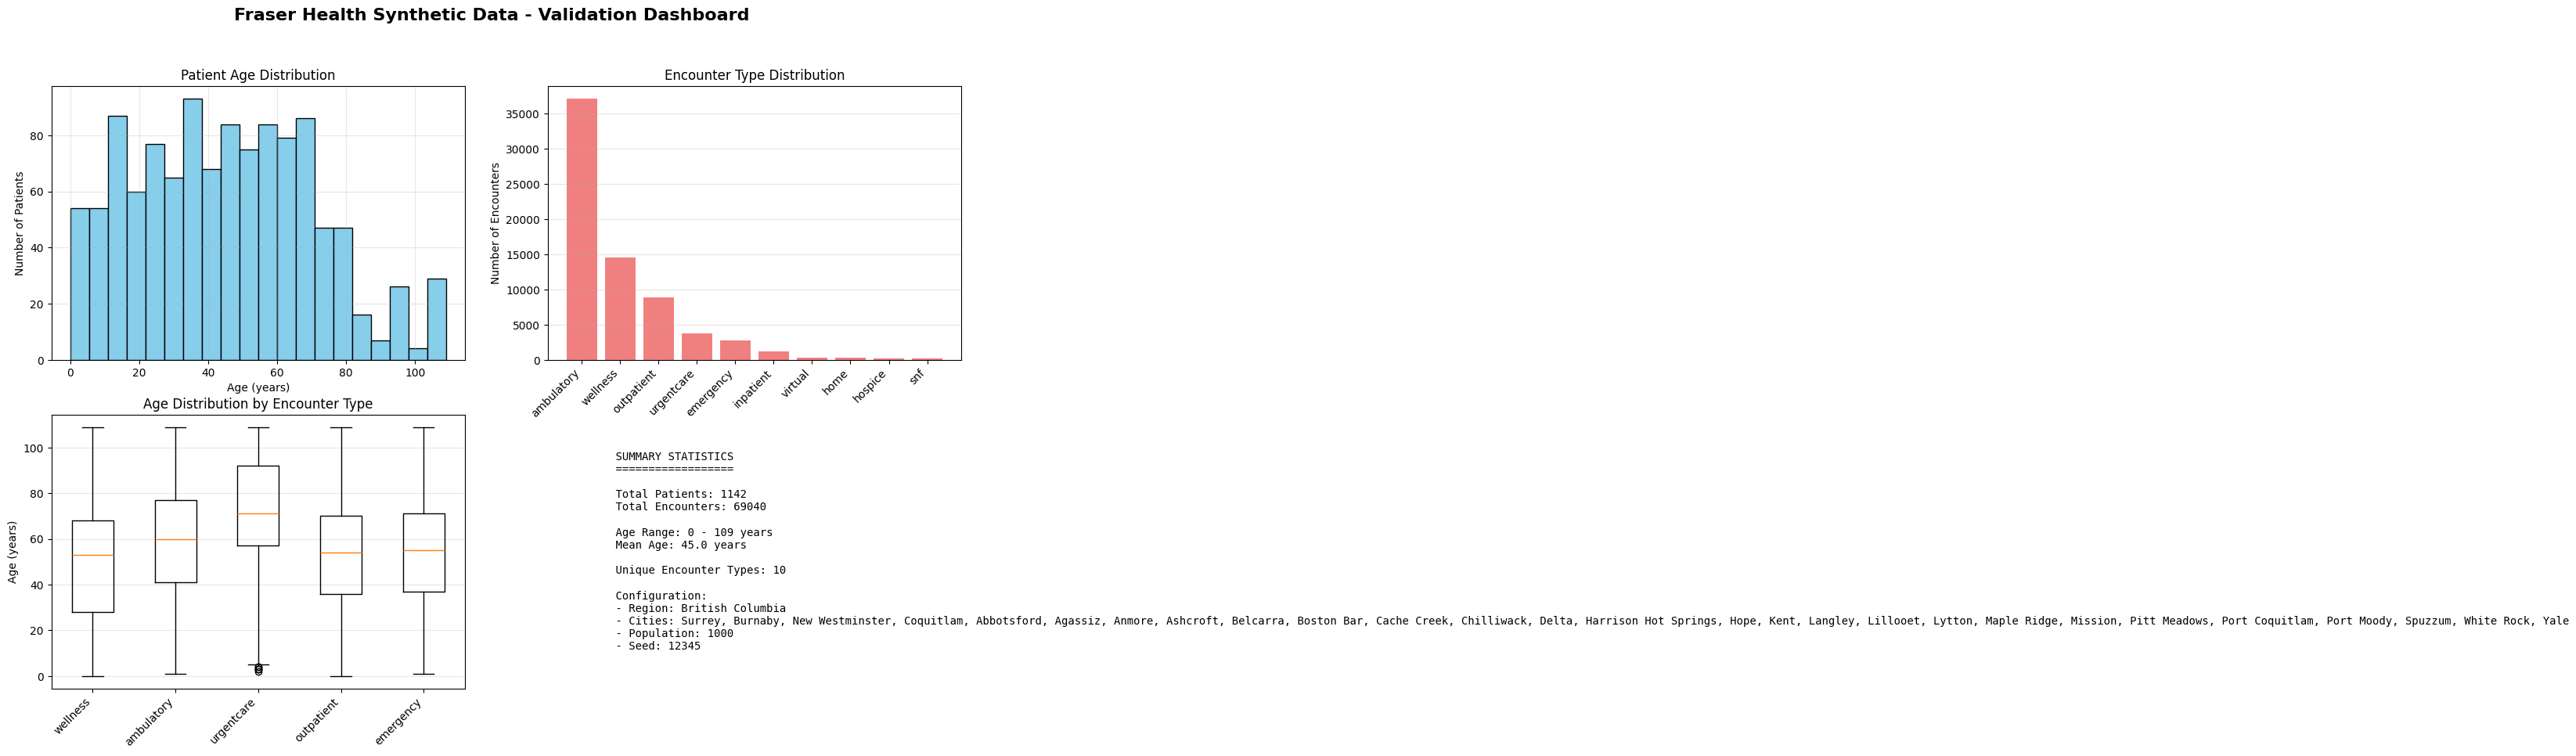

✓ Visualization complete!


In [61]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def calculate_age(birthdate_str):
    """Calculate age from birthdate string"""
    try:
        birthdate = pd.to_datetime(birthdate_str)
        today = pd.Timestamp.now()
        age = (today - birthdate).days // 365
        return age
    except:
        return None

def plot_age_vs_encounter_type(patients_df, encounters_df):
    """Create visualization of patient age vs encounter type"""
    if patients_df is None or encounters_df is None:
        print("⚠ Missing data for visualization")
        return
    
    print("Creating visualization...\n")
    
    # Calculate ages
    birthdate_col = 'BIRTHDATE' if 'BIRTHDATE' in patients_df.columns else 'birthdate'
    if birthdate_col in patients_df.columns:
        patients_df['AGE'] = patients_df[birthdate_col].apply(calculate_age)
    
    # Merge patients with encounters
    patient_id_col = 'Id' if 'Id' in patients_df.columns else 'ID' if 'ID' in patients_df.columns else 'id'
    encounter_patient_col = 'PATIENT' if 'PATIENT' in encounters_df.columns else 'patient'
    
    merged_df = encounters_df.merge(
        patients_df[['AGE', patient_id_col]],
        left_on=encounter_patient_col,
        right_on=patient_id_col,
        how='left'
    )
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Fraser Health Synthetic Data - Validation Dashboard', fontsize=16, fontweight='bold')
    
    # Plot 1: Age distribution
    if 'AGE' in patients_df.columns:
        axes[0, 0].hist(patients_df['AGE'].dropna(), bins=20, color='skyblue', edgecolor='black')
        axes[0, 0].set_xlabel('Age (years)')
        axes[0, 0].set_ylabel('Number of Patients')
        axes[0, 0].set_title('Patient Age Distribution')
        axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Encounter type distribution
    encounter_type_col = 'ENCOUNTERCLASS' if 'ENCOUNTERCLASS' in encounters_df.columns else 'encounterclass'
    if encounter_type_col in encounters_df.columns:
        encounter_counts = encounters_df[encounter_type_col].value_counts()
        axes[0, 1].bar(range(len(encounter_counts)), encounter_counts.values, color='lightcoral')
        axes[0, 1].set_xticks(range(len(encounter_counts)))
        axes[0, 1].set_xticklabels(encounter_counts.index, rotation=45, ha='right')
        axes[0, 1].set_ylabel('Number of Encounters')
        axes[0, 1].set_title('Encounter Type Distribution')
        axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Age vs Encounter Type (box plot)
    if 'AGE' in merged_df.columns and encounter_type_col in merged_df.columns:
        encounter_types = merged_df[encounter_type_col].unique()[:5]  # Top 5 types
        age_data = [merged_df[merged_df[encounter_type_col] == et]['AGE'].dropna() 
                   for et in encounter_types]
        
        # Use tick_labels instead of deprecated 'labels' parameter (Matplotlib 3.9+)
        axes[1, 0].boxplot(age_data, tick_labels=encounter_types)
        axes[1, 0].set_xticklabels(encounter_types, rotation=45, ha='right')
        axes[1, 0].set_ylabel('Age (years)')
        axes[1, 0].set_title('Age Distribution by Encounter Type')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Summary statistics
    axes[1, 1].axis('off')
    summary_text = f"""
    SUMMARY STATISTICS
    ==================
    
    Total Patients: {len(patients_df)}
    Total Encounters: {len(encounters_df)}
    
    Age Range: {patients_df['AGE'].min():.0f} - {patients_df['AGE'].max():.0f} years
    Mean Age: {patients_df['AGE'].mean():.1f} years
    
    Unique Encounter Types: {encounters_df[encounter_type_col].nunique()}
    
    Configuration:
    - Region: {TARGET_REGION}
    - Cities: {', '.join(TARGET_CITIES)}
    - Population: {POPULATION_SIZE}
    - Seed: {RANDOM_SEED}
    """
    axes[1, 1].text(0.1, 0.5, summary_text, 
                    fontsize=10, 
                    verticalalignment='center',
                    fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualization complete!")

if patients_df is not None and encounters_df is not None:
    plot_age_vs_encounter_type(patients_df, encounters_df)
else:
    print("⚠ Cannot create visualization - missing data")

### 4.5 Final Summary

In [62]:
print("="*70)
print("FRASER HEALTH SYNTHETIC DATA GENERATION - SUMMARY")
print("="*70)
print()
print("✓ Environment Setup Complete")
print(f"  - Java: {'✓' if java_ok else '✗'}")
print(f"  - Synthea Repository: {'✓' if synthea_ok else '✗'}")
print(f"  - Synthea-International: {'✓' if international_ok else '✗'}")
print(f"  - Synthea JAR: {'✓' if synthea_jar else '✗'}")
print()
print("✓ Configuration")
print(f"  - Target Region: {TARGET_REGION} ({TARGET_STATE_CODE})")
print(f"  - Target Cities: {', '.join(TARGET_CITIES)}")
print(f"  - Population Size: {POPULATION_SIZE}")
print(f"  - Random Seed: {RANDOM_SEED}")
print()
print("✓ Data Preparation")
print(f"  - Zipcodes Data: {'✓' if prepared_zipcodes is not None else '✗'}")
print(f"  - Demographics Data: {'✓' if prepared_demographics is not None else '✗'}")
print(f"  - Hospitals Data: {'✓' if prepared_hospitals is not None else '✗'}")
print()
print("✓ Simulation")
print(f"  - Execution: {'✓ Success' if simulation_ok else '✗ Not Run or Failed'}")
print()
print("✓ Validation")
print(f"  - Patients Generated: {len(patients_df) if patients_df is not None else 0}")
print(f"  - Encounters Generated: {len(encounters_df) if encounters_df is not None else 0}")
print()
print("Output Location:")
print(f"  - {SYNTHEA_DIR / 'output' / 'csv'}")
print()
print("="*70)

FRASER HEALTH SYNTHETIC DATA GENERATION - SUMMARY

✓ Environment Setup Complete
  - Java: ✓
  - Synthea Repository: ✓
  - Synthea-International: ✓
  - Synthea JAR: ✓

✓ Configuration
  - Target Region: British Columbia (BC)
  - Target Cities: Surrey, Burnaby, New Westminster, Coquitlam, Abbotsford, Agassiz, Anmore, Ashcroft, Belcarra, Boston Bar, Cache Creek, Chilliwack, Delta, Harrison Hot Springs, Hope, Kent, Langley, Lillooet, Lytton, Maple Ridge, Mission, Pitt Meadows, Port Coquitlam, Port Moody, Spuzzum, White Rock, Yale
  - Population Size: 1000
  - Random Seed: 12345

✓ Data Preparation
  - Zipcodes Data: ✓
  - Demographics Data: ✓
  - Hospitals Data: ✓

✓ Simulation
  - Execution: ✓ Success

✓ Validation
  - Patients Generated: 1142
  - Encounters Generated: 69040

Output Location:
  - /workspaces/bc-synthetic-health/synthea/output/csv



## Section 5: Output Management (Optional)

The following cells allow you to:
1. **Persist outputs** - Copy generated CSV files to the repo for version control
2. **Clean outputs** - Remove persisted outputs from the repo

> ⚠️ **Note**: Generated data can be large. Only persist if you need to share or version control the outputs.

### 5.1 Persist Generated Outputs to Repository

Run this cell to copy generated CSV files to the `output/` directory in the repo.
These files can then be committed for sharing or reproducibility.

In [63]:
import shutil
from pathlib import Path

def persist_outputs_to_repo(include_fhir=False):
    """
    Copy generated outputs from synthea/output to repo's output/ directory.
    
    Args:
        include_fhir: If True, also copy FHIR JSON bundles (can be very large)
    """
    source_dir = SYNTHEA_DIR / "output"
    target_dir = WORK_DIR / "output"
    
    if not source_dir.exists():
        print("✗ No Synthea output found. Run the simulation first.")
        return False
    
    print("Persisting generated outputs to repository...\n")
    
    # Create target directory
    target_dir.mkdir(exist_ok=True)
    
    # Copy CSV files
    csv_source = source_dir / "csv"
    csv_target = target_dir / "csv"
    
    if csv_source.exists():
        if csv_target.exists():
            shutil.rmtree(csv_target)
        shutil.copytree(csv_source, csv_target)
        
        csv_files = list(csv_target.glob("*.csv"))
        total_size = sum(f.stat().st_size for f in csv_files) / (1024 * 1024)  # MB
        print(f"✓ Copied {len(csv_files)} CSV files ({total_size:.2f} MB)")
        print(f"  Location: {csv_target.relative_to(WORK_DIR)}/")
    
    # Optionally copy FHIR bundles
    if include_fhir:
        fhir_source = source_dir / "fhir"
        fhir_target = target_dir / "fhir"
        
        if fhir_source.exists():
            if fhir_target.exists():
                shutil.rmtree(fhir_target)
            shutil.copytree(fhir_source, fhir_target)
            
            fhir_files = list(fhir_target.glob("*.json"))
            total_size = sum(f.stat().st_size for f in fhir_files) / (1024 * 1024)
            print(f"✓ Copied {len(fhir_files)} FHIR bundles ({total_size:.2f} MB)")
            print(f"  Location: {fhir_target.relative_to(WORK_DIR)}/")
    
    # Create a metadata file
    metadata_file = target_dir / "generation_metadata.txt"
    with open(metadata_file, 'w') as f:
        f.write(f"Fraser Health Synthetic Data Generation\n")
        f.write(f"=" * 50 + "\n\n")
        f.write(f"Generated: {datetime.now().isoformat()}\n")
        f.write(f"Region: {TARGET_REGION}\n")
        f.write(f"Cities: {', '.join(TARGET_CITIES)}\n")
        f.write(f"Population: {POPULATION_SIZE}\n")
        f.write(f"Random Seed: {RANDOM_SEED}\n")
        f.write(f"Patients: {len(patients_df) if patients_df is not None else 'N/A'}\n")
        f.write(f"Encounters: {len(encounters_df) if encounters_df is not None else 'N/A'}\n")
    print(f"✓ Created generation_metadata.txt")
    
    print(f"\n✓ Outputs persisted to: {target_dir.relative_to(WORK_DIR)}/")
    print("\nTo commit these outputs, run:")
    print("  git add output/")
    print("  git commit -m 'Add generated synthetic health data'")
    
    return True

# === UNCOMMENT TO PERSIST OUTPUTS ===
persist_outputs_to_repo(include_fhir=False)  # CSV only (smaller)
# persist_outputs_to_repo(include_fhir=True)   # CSV + FHIR (larger)

Persisting generated outputs to repository...



✓ Copied 18 CSV files (636.85 MB)
  Location: output/csv/
✓ Created generation_metadata.txt

✓ Outputs persisted to: output/

To commit these outputs, run:
  git add output/
  git commit -m 'Add generated synthetic health data'


True

### 5.2 Clean Persisted Outputs from Repository

Run this cell to remove persisted outputs from the repo.
This is useful before committing if you don't want to include generated data.

In [64]:
def clean_persisted_outputs(also_clean_synthea_output=False):
    """
    Remove persisted outputs from the repository.
    
    Args:
        also_clean_synthea_output: If True, also clean synthea/output directory
    """
    repo_output_dir = WORK_DIR / "output"
    synthea_output_dir = SYNTHEA_DIR / "output"
    
    print("Cleaning persisted outputs from repository...\n")
    
    # Clean repo output directory
    if repo_output_dir.exists():
        shutil.rmtree(repo_output_dir)
        print(f"✓ Removed: {repo_output_dir.relative_to(WORK_DIR)}/")
    else:
        print(f"ℹ No persisted outputs found at: {repo_output_dir.relative_to(WORK_DIR)}/")
    
    # Optionally clean Synthea output
    if also_clean_synthea_output:
        if synthea_output_dir.exists():
            shutil.rmtree(synthea_output_dir)
            print(f"✓ Removed: {synthea_output_dir.relative_to(WORK_DIR)}/")
        else:
            print(f"ℹ No Synthea output found at: {synthea_output_dir.relative_to(WORK_DIR)}/")
    
    print("\n✓ Cleanup complete!")
    
    # Show git status hint
    print("\nTo unstage removed files from git, run:")
    print("  git restore --staged output/")

# === UNCOMMENT TO CLEAN OUTPUTS ===
# clean_persisted_outputs()                          # Clean repo output only
# clean_persisted_outputs(also_clean_synthea_output=True)  # Clean both